# Install all kinds of requirements

In [3]:
!apt install libglfw3-dev -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglfw3-dev is already the newest version (3.3.6-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [4]:
# @markdown ## ⚠️ PLEASE NOTE:
# @markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

from IPython.display import HTML, clear_output

%pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install matplotlib
%pip install IPython
%pip install flax
clear_output()

import functools
import os
from datetime import datetime

import jax
import matplotlib.pyplot as plt
from jax import numpy as jp

try:
    import brax
except ImportError:
    %pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

import flax
from brax import envs
from brax import geometry as braxgeo
from brax.io import html, json, model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sacb

## Double check GPU

In [5]:
!nvidia-smi

Sat May 13 08:23:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:01:00.0 Off |                  N/A |
|100%   19C    P8               36W / 420W|      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Train the agent on the base reward

In [6]:
env = envs.create(env_name="ant", backend="positional")

In [7]:
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

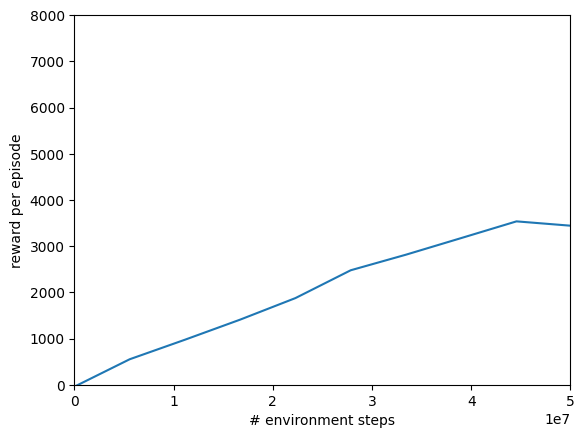

time to jit: 0:00:22.258896
time to train: 0:02:56.283432


In [8]:
max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics["eval/episode_reward"])
    clear_output(wait=True)
    plt.xlim([0, 50_000_000])
    plt.ylim([min_y, max_y])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.plot(xdata, ydata)
    plt.show()


make_inference_fn, params, _ = ppo.train(
    environment=env,
    progress_fn=progress,
    num_timesteps=50_000_000,
    num_evals=10,
    reward_scaling=10,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=5,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096,
    batch_size=2048,
    seed=1,
)


print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [9]:
model.save_params("/tmp/params", params)
params = model.load_params("/tmp/params")
inference_fn = make_inference_fn(params)

In [10]:
# @title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name="ant", backend="positional")

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

# Make the other reward functions

In [4]:
@jax.jit
def flying_reward(state: envs.State, action: jax.Array) -> jax.Array:
    contact = braxgeo.contact(  # type: brax.base.Contact
        self.sys, state.pipeline_state.x  # type: ignore
    )

    num_contacts = contact.link_idx[0].shape[0]  # type: ignore

    return state.reward + num_contacts * -0.25

In [5]:
@jax.jit
def lazy_reward(state: envs.State, action: jax.Array) -> jax.Array:
    movement = jp.linalg.norm(action, axis=-1)

    return state.reward + movement * -0.5

In [6]:
@jax.jit
def steady_reward(state: envs.State, action: jax.Array) -> jax.Array:
    body_y_vel = state.pipeline_state.xd.vel[0]  # type: ignore

    return state.reward + body_y_vel**2 * -0.5

In [7]:
@jax.jit
def tall_reward(state: envs.State, action: jax.Array) -> jax.Array:
    z_height = state.pipeline_state.x.pos[0][2]  # type: ignore

    return state.reward + z_height * 0.25

## Add reward functions to reward_flavors array

In [24]:
reward_flavors = [flying_reward, lazy_reward, steady_reward, tall_reward]

# Collecting Rollouts to Rank

In [13]:
env = envs.create(env_name="ant", backend="positional")

jit_vec_env_reset = jax.jit(env.reset)
jit_vec_env_step = jax.jit(env.step)

rollouts = []
rng = jax.random.PRNGKey(seed=1)
states = jit_env_reset(rng=rng)

parallel_envs = 4096
num_rollouts = 16384
trajectory_length = 1000

In [14]:
vmapped_reset = jax.vmap(jit_env_reset)
vmapped_step = jax.vmap(jit_env_step)
vmapped_inference_fn = jax.vmap(jit_inference_fn)

In [17]:
@jax.jit
def collect_parallel_rollout(
    rng: jax.Array,
):
    rng, reset_rng = jax.random.split(rng)
    rngs = jax.random.split(rng, parallel_envs)
    states = vmapped_reset(rng=rngs)
    
    rollout = []
    
    for _ in range(trajectory_length):
        rng, act_rng = jax.random.split(rng)
        rngs = jax.random.split(act_rng, parallel_envs)
        acts, _ = vmapped_inference_fn(states.obs, rngs)
        rollout.append((states, acts))
        states = vmapped_step(states, acts)
        
        
        
    return rollout

In [18]:
rollouts = []

for _ in range(num_rollouts // parallel_envs):
    new_rollouts = collect_parallel_rollout(rng)
    
    rollouts.append(new_rollouts) 


KeyboardInterrupt



## Concatenate together parallel rollouts

In [175]:
type(jax.tree_util.tree_flatten(rollout_batch)[0][0][1])

jaxlib.xla_extension.ArrayImpl

In [18]:
zipped_batch_leaves = zip(*[
        jax.tree_util.tree_flatten(rollout_batch)[0]
        for rollout_batch in rollouts
    ])

for parallel_leaves in zipped_batch_leaves:
    display(parallel_leaves)
    jp.concatenate(jp.array(parallel_leaves))

In [19]:
batches = rollouts

In [21]:
# @jax.jit
# def concatenate_rollout_batches(batches):
flat_catted_leaves = \
[
    # Concatenate together the leaves of all of the rollouts from the batches
    jp.concatenate(jp.array(parallel_leaves))

    # Zip together similar leaves from the lists of arrays that tree_flatten gives us
    for parallel_leaves in zip(*[
        jax.tree_util.tree_flatten(rollout_batch)[0]
        for rollout_batch in batches
    ])
]

all_rollouts = jax.tree_util.tree_unflatten(flat_catted_leaves, jax.tree_util.tree_structure(batches[0]))

IndexError: list index out of range

In [179]:
# catted_rollouts = concatenate_rollout_batches(rollouts)

KeyboardInterrupt: 